In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
import multiprocessing as mp

%matplotlib inline

In [2]:
%%time

DATA_PATH = "data/2008.csv"

df = pd.read_csv(DATA_PATH)
df = df[df.Month == 6] # let's take just 1 month
df = df[(df.Cancelled == 0) & ~df.ArrTime.isna() & ~df.DepTime.isna()]

dates = pd.to_datetime(df.rename(columns={'DayofMonth': 'Day'})[['Year', 'Month', 'Day']])
dateTs = dates.astype(int) // 10**9
arrTs = dateTs + (df.ArrTime / 100) * 3600 + 86400 * (df.ArrTime <= df.DepTime).astype(int)
df['arrTs'] = arrTs.astype(int)

df = df[['Origin', 'Dest', 'arrTs']].sort_values('arrTs')

CPU times: user 14.3 s, sys: 942 ms, total: 15.2 s
Wall time: 15.3 s


In [3]:
def simulate(p, start_node='ABE', n_repeat=10):
    results = []
    for _ in range(n_repeat):
        
        node_infection = {start_node: df.arrTs.min()}
        
        for _, row in df.iterrows():
            if row.Origin in node_infection and row.Dest not in node_infection:
                if np.random.rand() < p:
                    node_infection[row.Dest] = int(row.arrTs)
        
        results.append(node_infection)
    
    return results

In [4]:
%%time

p=[0.01, 0.05, 0.1, 0.5, 1.] 

with mp.Pool(mp.cpu_count()) as pool:
    simulations = pool.map(simulate, p)

CPU times: user 785 ms, sys: 356 ms, total: 1.14 s
Wall time: 28min 52s


In [20]:
from functools import reduce

def make_run_df(run):
    data = [
        {'infected': node, 'time': ts // 12 // 3600} 
        for node, ts in run.items()
    ]
    tmp = pd.DataFrame(data).groupby('time').count().reset_index()
    tmp['total_infected'] = tmp.infected.cumsum()
    tmp.time = pd.to_datetime(tmp.time * 12 * 3600, origin='unix', unit='s')
    tmp = tmp.sort_values('time').set_index('time').sort_index()
    return tmp

def average_runs(simulation):
    run_dfs = [make_run_df(run) for run in simulation]
    common_index = pd.concat(run_dfs).index.unique().sort_values()
    
    tmp = pd.concat([rdf.reindex(common_index).fillna(method='ffill').fillna(0) for rdf in run_dfs])
    return pd.DataFrame({
        'mean_infected': tmp.groupby(tmp.index).median().total_infected,
        'infected_std': tmp.groupby(tmp.index).std().total_infected,
    })

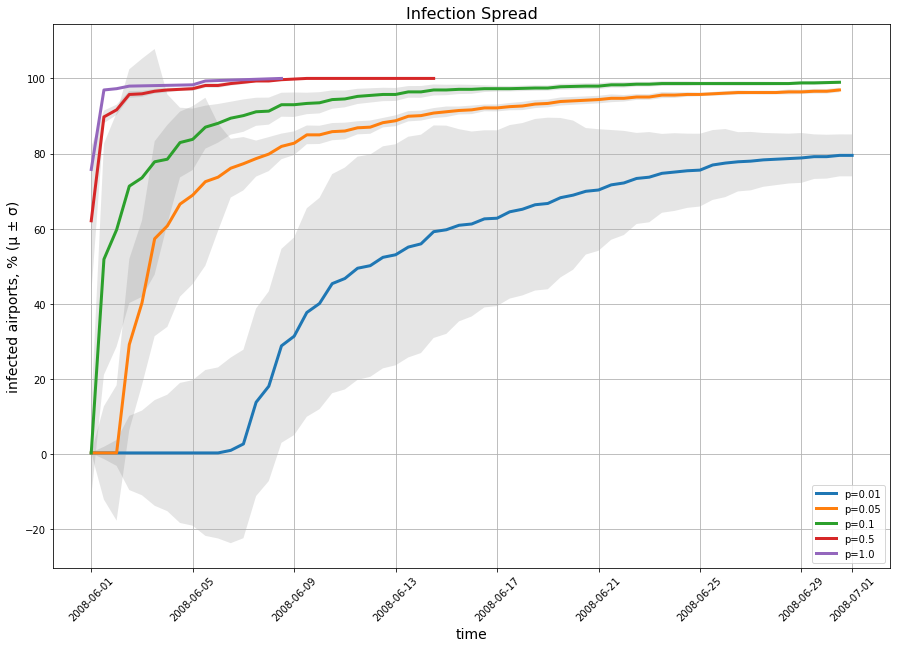

In [30]:
sdfs = [average_runs(runs) for runs in simulations]

plt.figure(figsize=(15, 10))

dest_num = df.Dest.nunique()

for proba, sdf in zip(p, sdfs):
    plt.plot(
        sdf.index, 
        sdf.mean_infected * 100 / dest_num, 
        label=f'p={proba}', 
        linewidth=3
    )
    plt.fill_between(
        sdf.index, 
        (sdf.mean_infected+sdf.infected_std) * 100 / dest_num, 
        (sdf.mean_infected-sdf.infected_std) * 100 / dest_num, 
        facecolor='gray', 
        alpha=0.2
    )
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.grid()
plt.title('Infection Spread', fontsize=16)
plt.xlabel('time', fontsize=14)
plt.ylabel('infected airports, % (μ ± σ)', fontsize=14)
plt.show()